In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
images = np.load("/kaggle/input/forex-full-images-cluster-labels/images.npy")
labels = np.load("/kaggle/input/forex-full-images-cluster-labels/labels.npy")

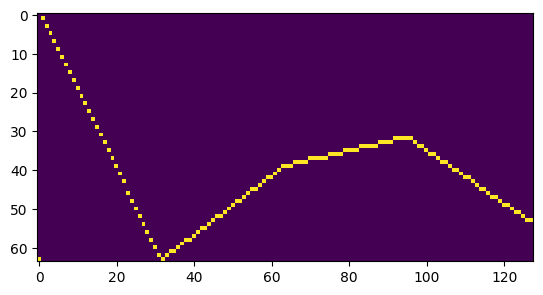

In [6]:
plt.imshow(images[100].reshape(64, 128))

In [14]:
means = {}
std = {}

for i in range(labels.max()+1):
    means[i] = images[labels == i].mean(axis=0)
    std[i] = images[labels == i].std(axis=0)

In [15]:
means.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [16]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

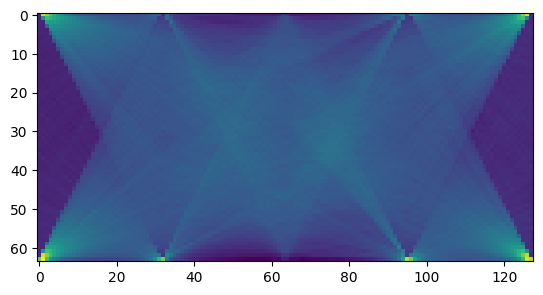

In [19]:
plt.imshow(std[63].reshape(64, 128))

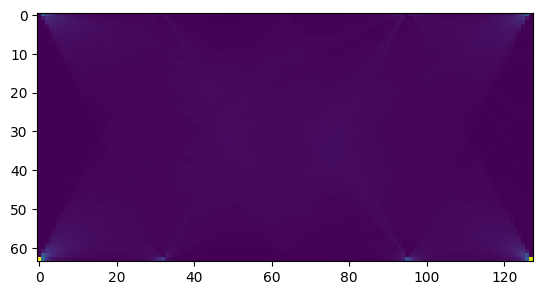

In [20]:
plt.imshow(means[63].reshape(64, 128))

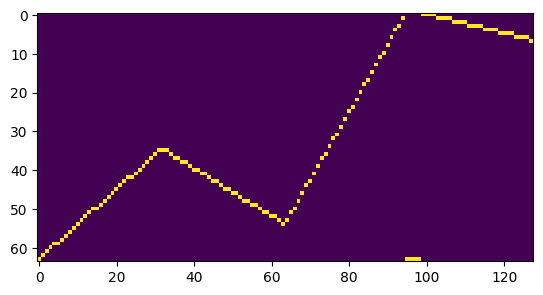

In [21]:
plt.imshow(images[labels == 63][0].reshape(64, 128))

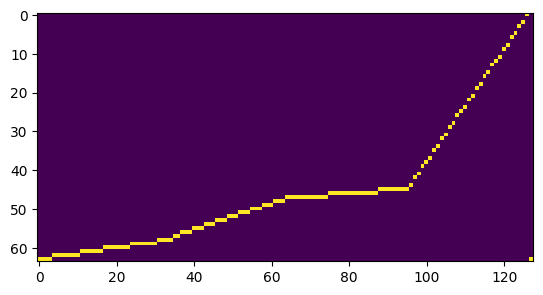

In [22]:
plt.imshow(images[labels == 63][100].reshape(64, 128))

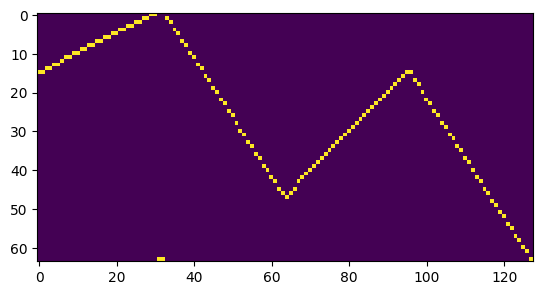

In [23]:
plt.imshow(images[labels == 63][123].reshape(64, 128))

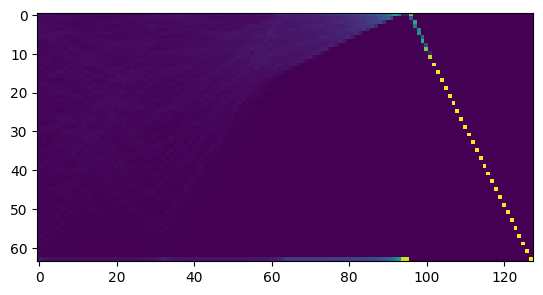

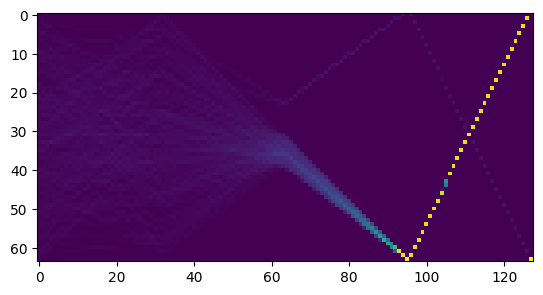

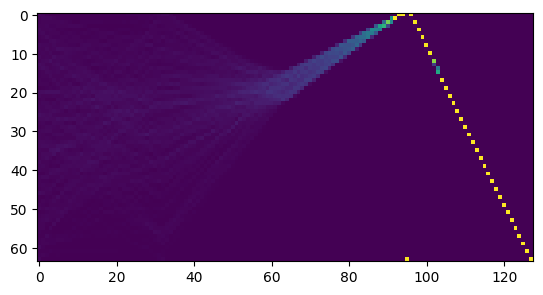

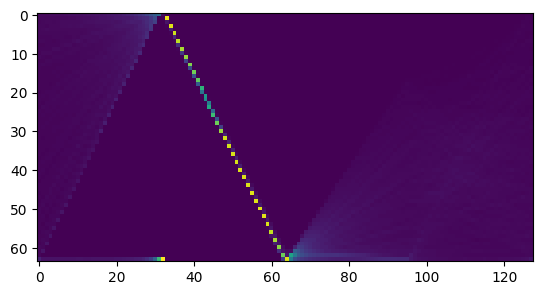

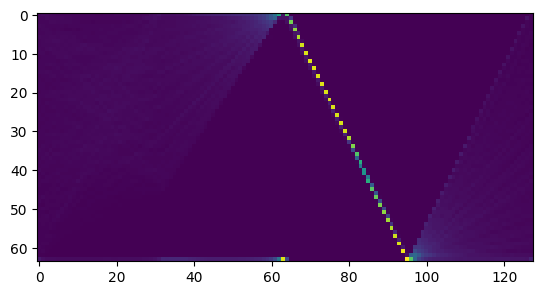

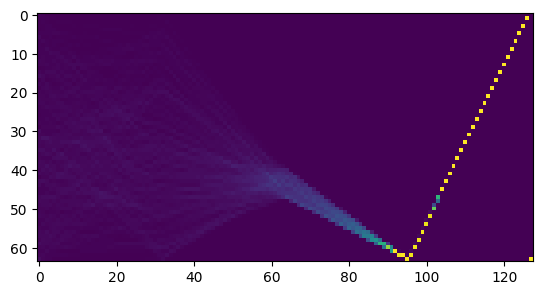

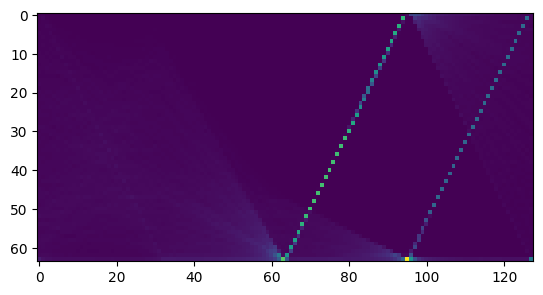

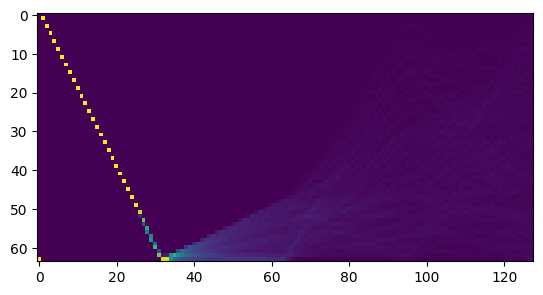

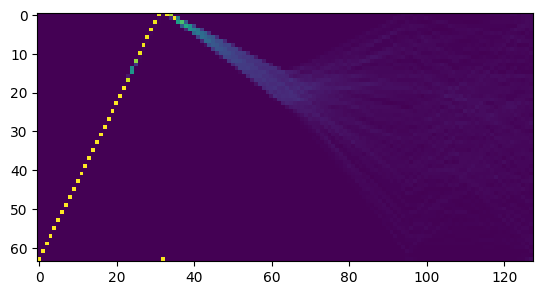

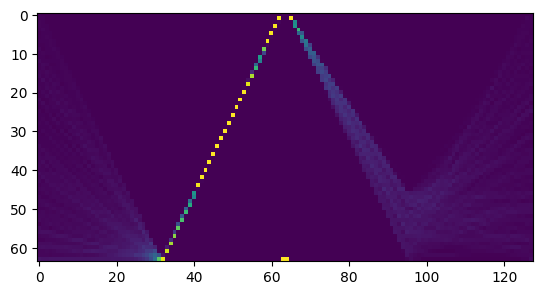

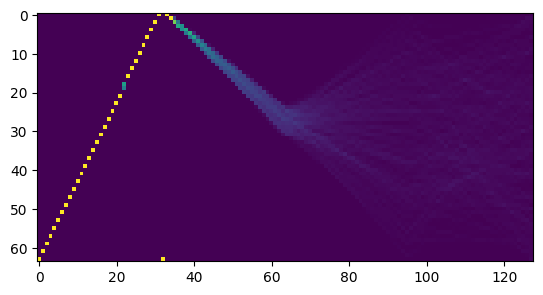

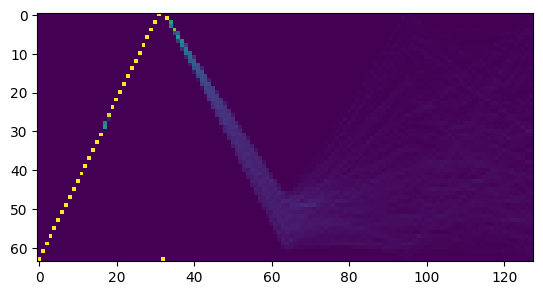

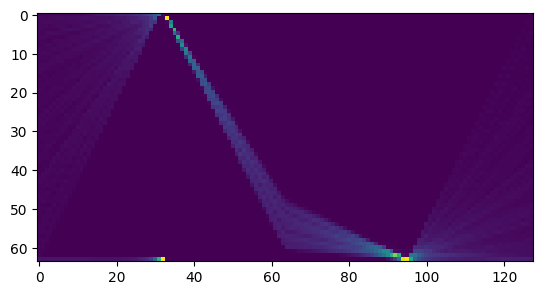

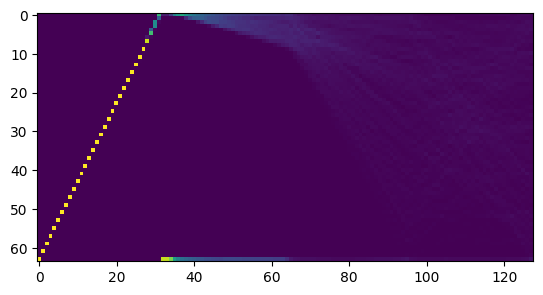

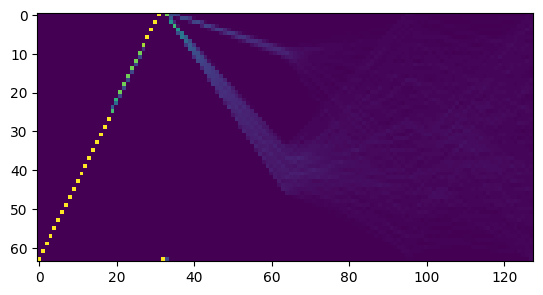

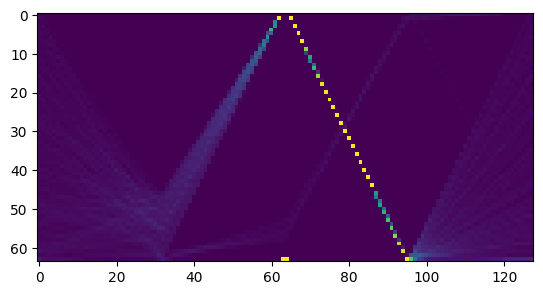

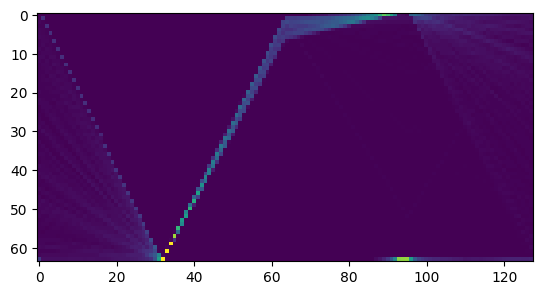

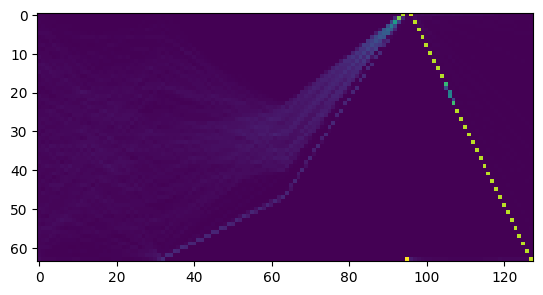

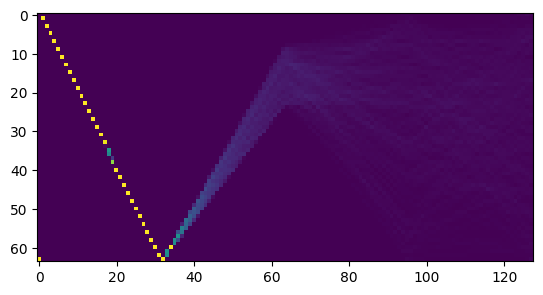

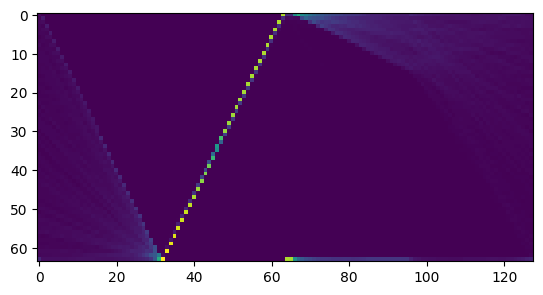

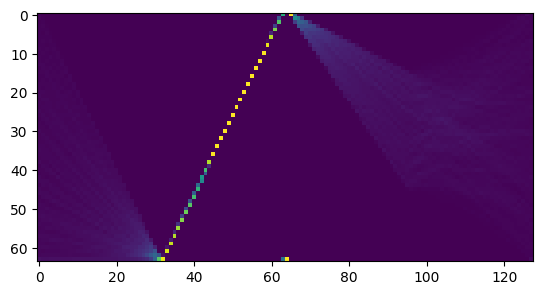

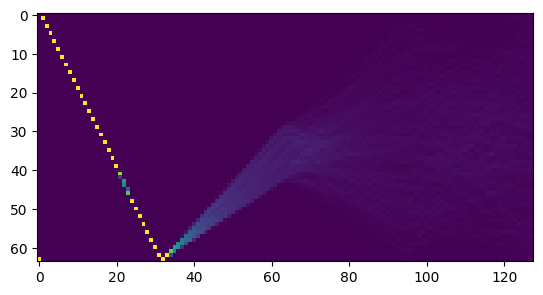

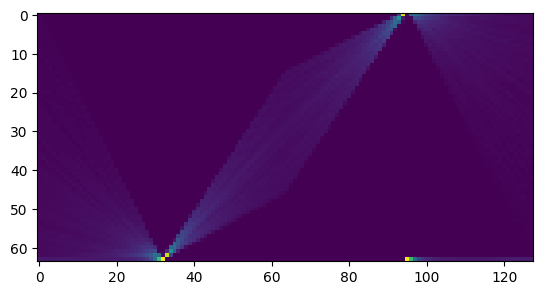

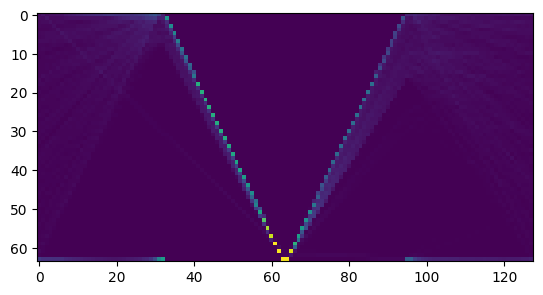

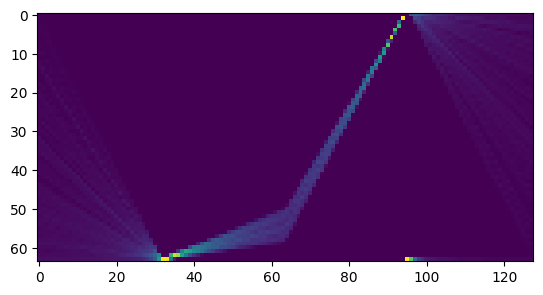

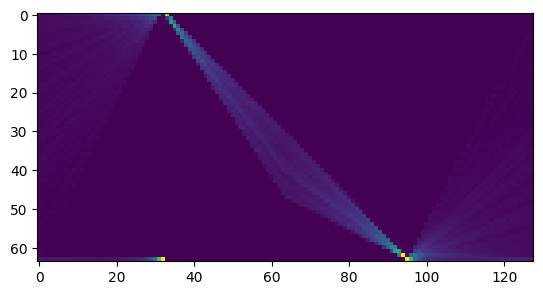

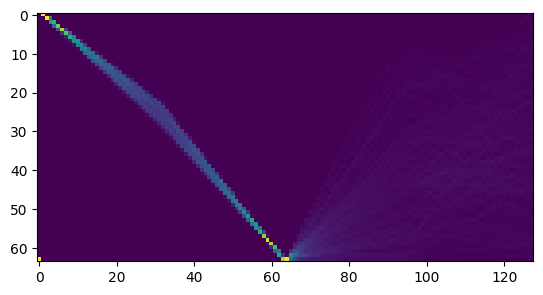

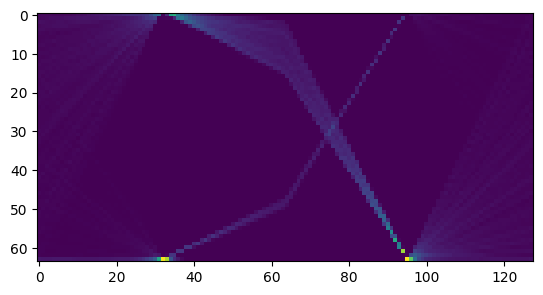

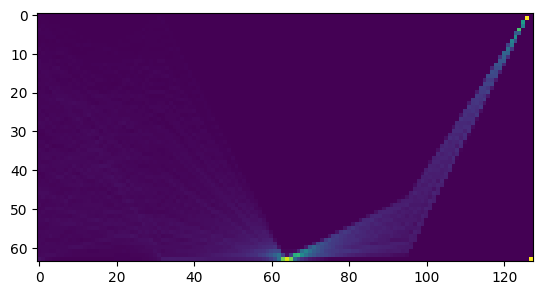

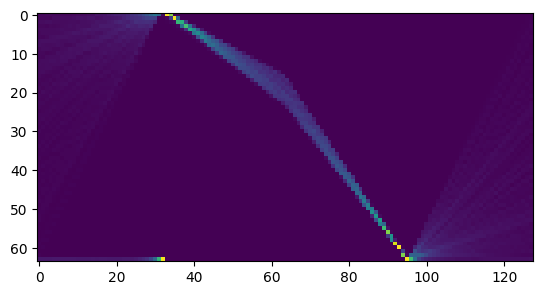

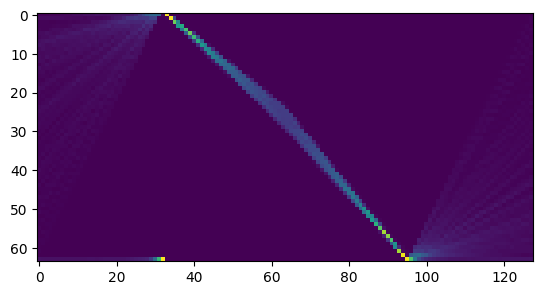

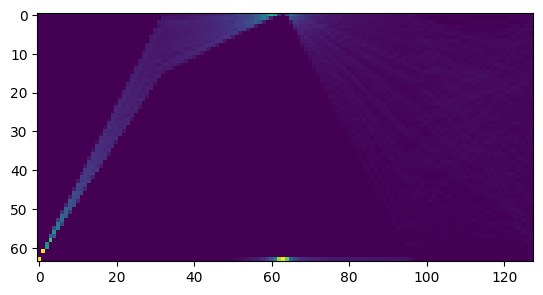

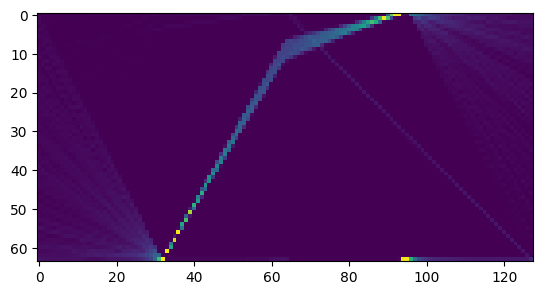

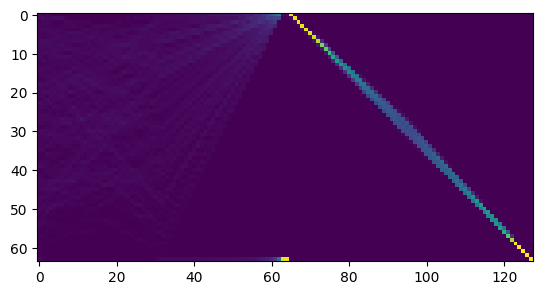

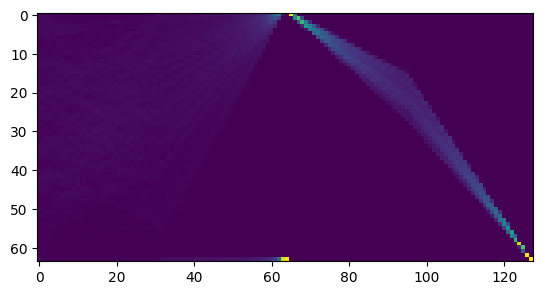

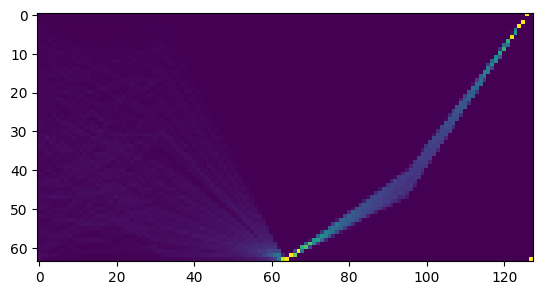

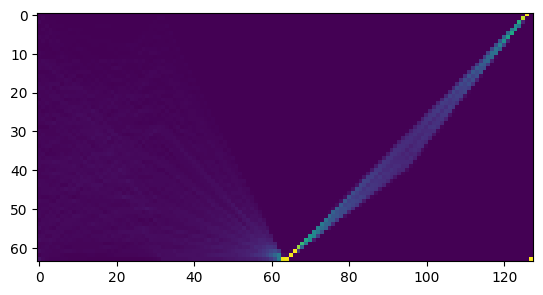

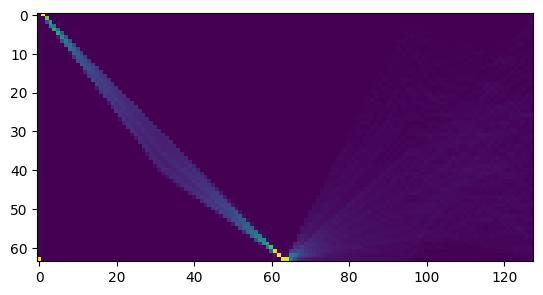

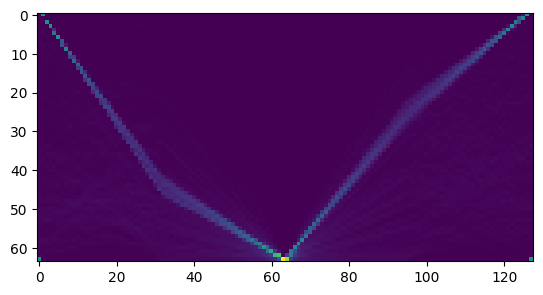

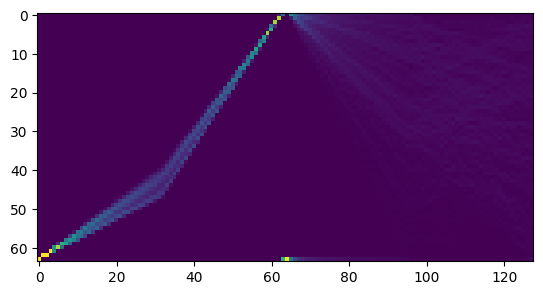

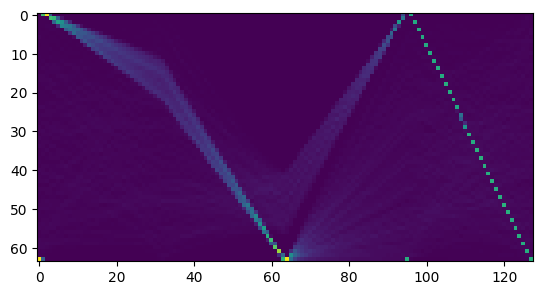

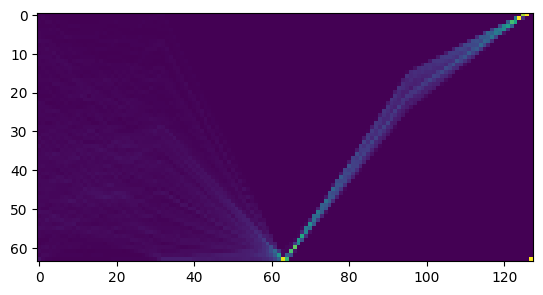

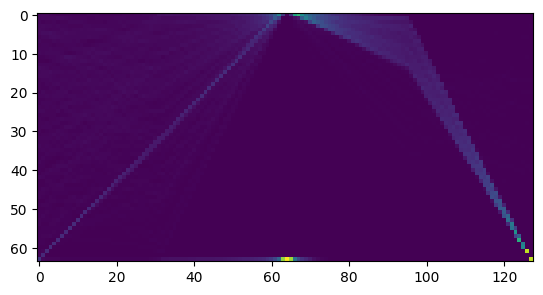

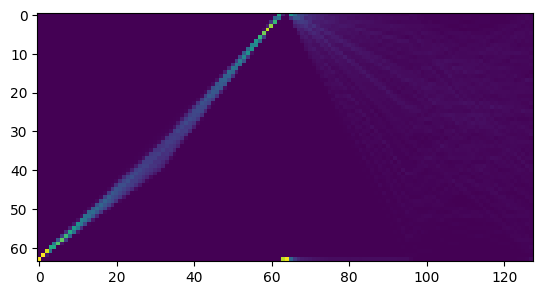

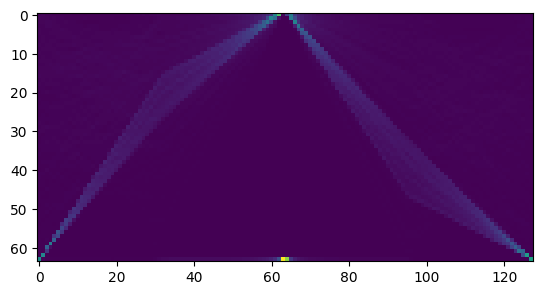

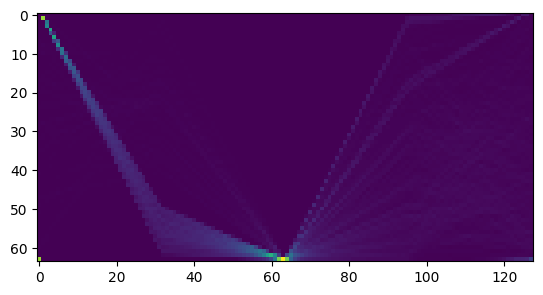

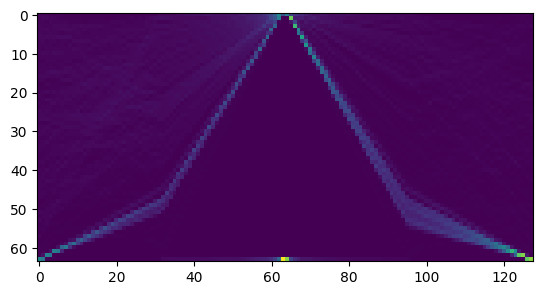

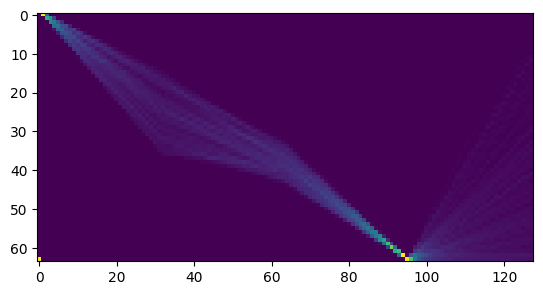

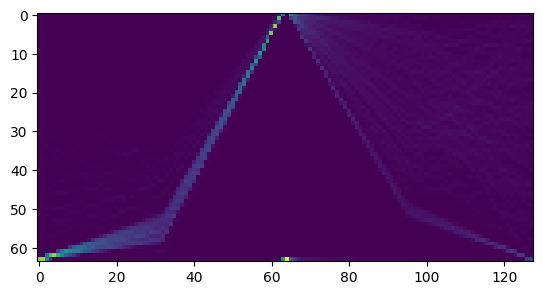

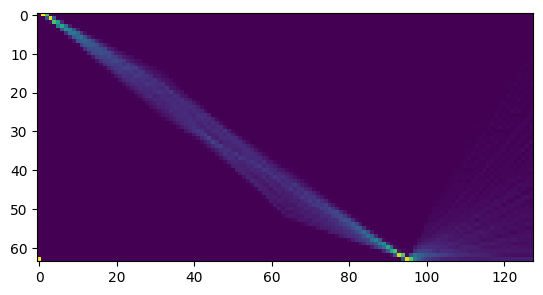

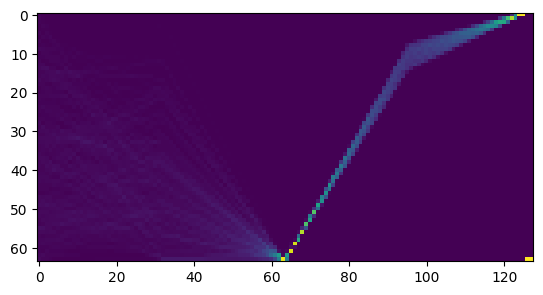

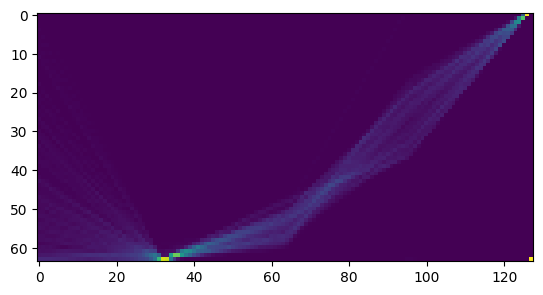

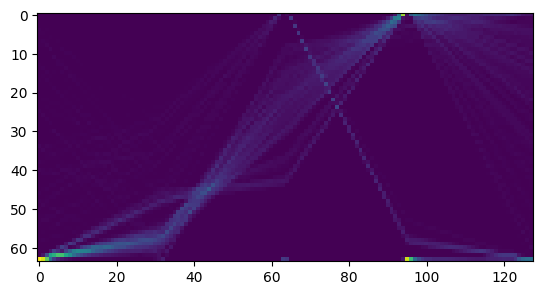

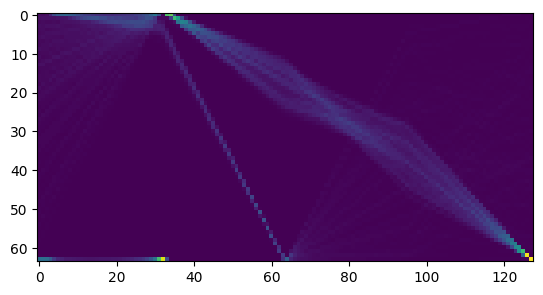

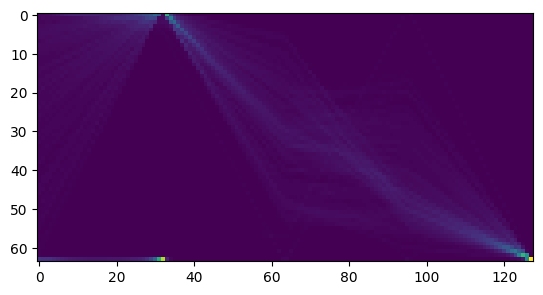

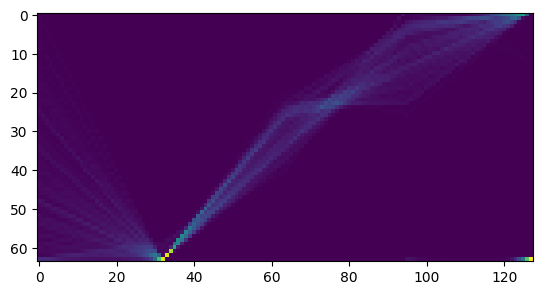

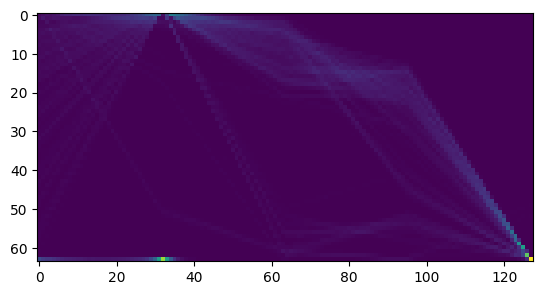

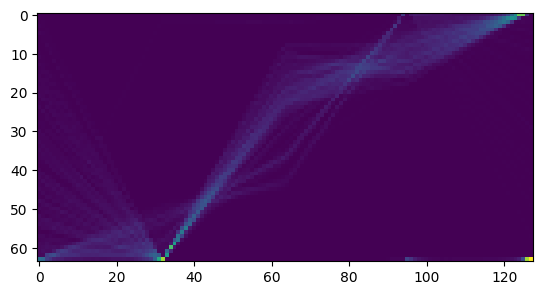

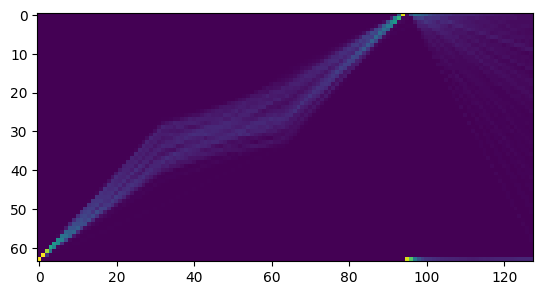

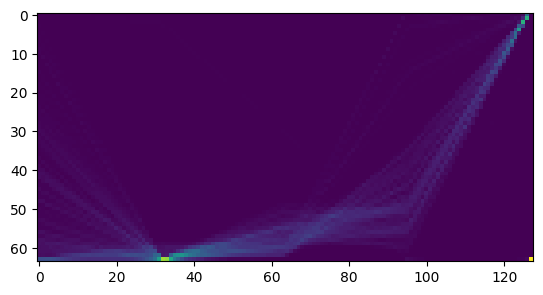

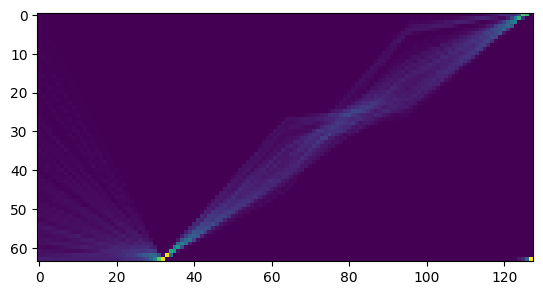

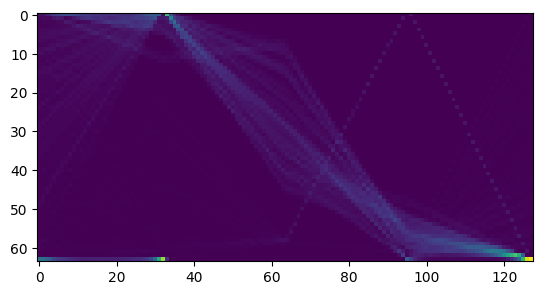

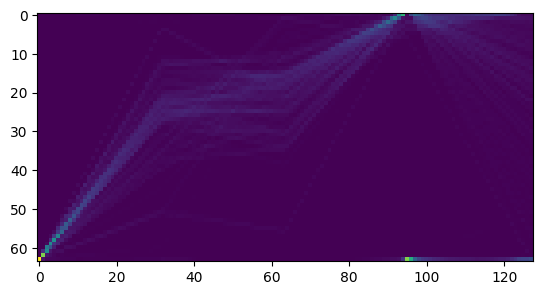

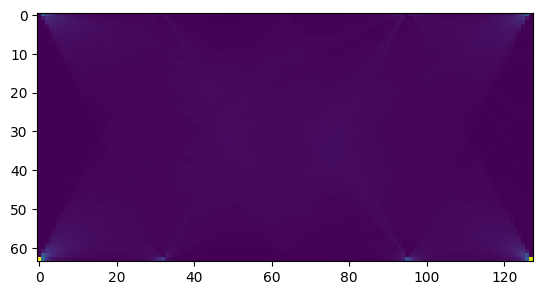

In [24]:
for label in means.keys():
    plt.imshow(means[label].reshape(64, 128))
    plt.show()

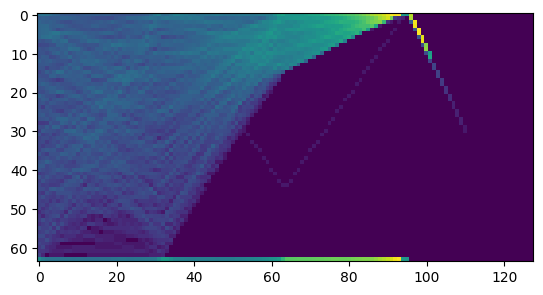

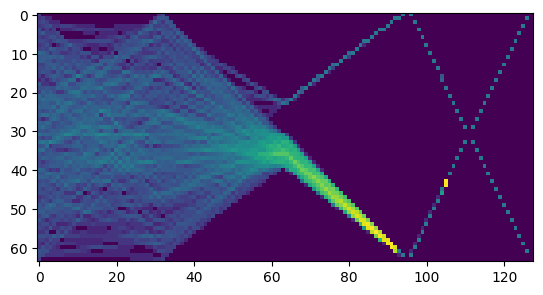

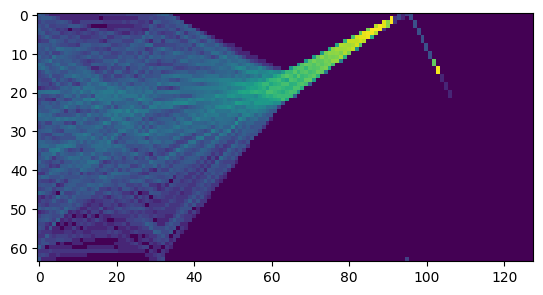

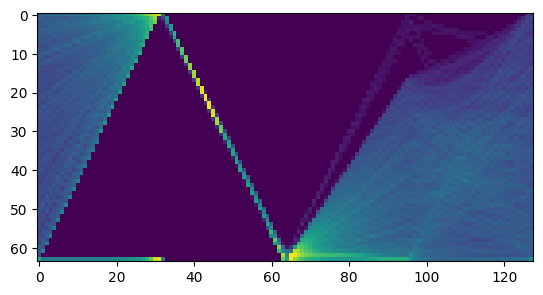

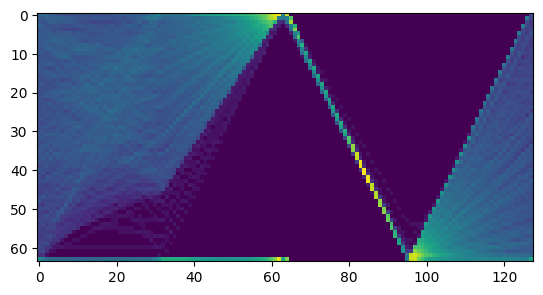

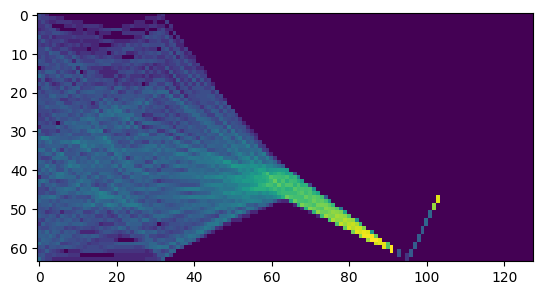

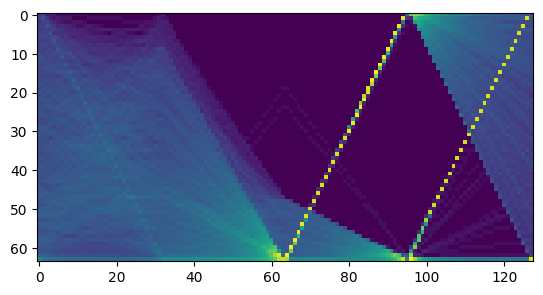

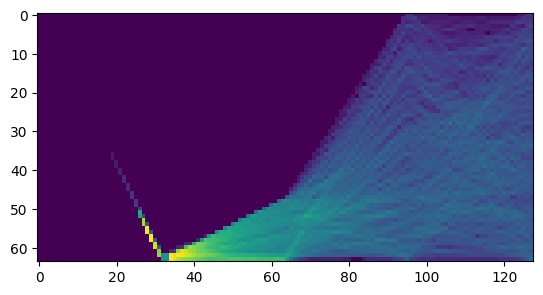

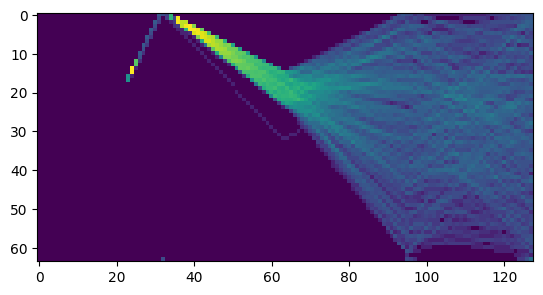

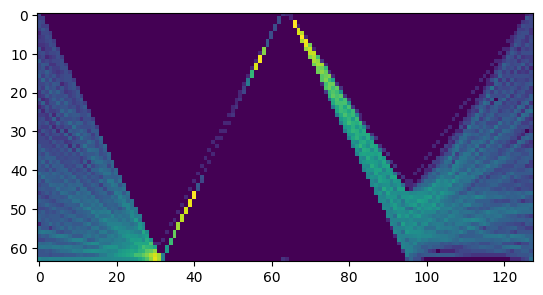

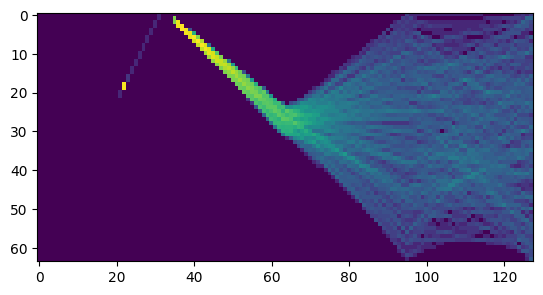

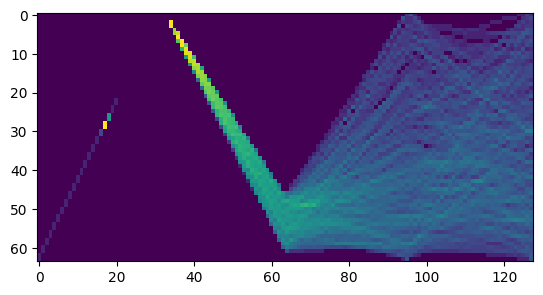

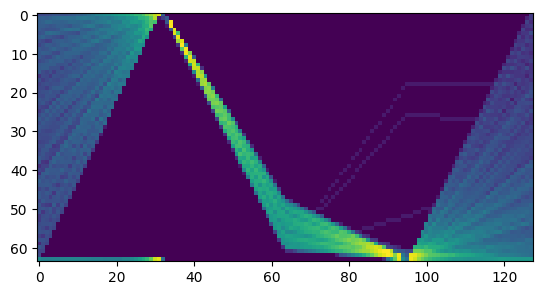

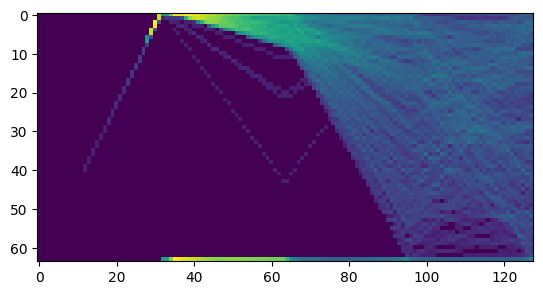

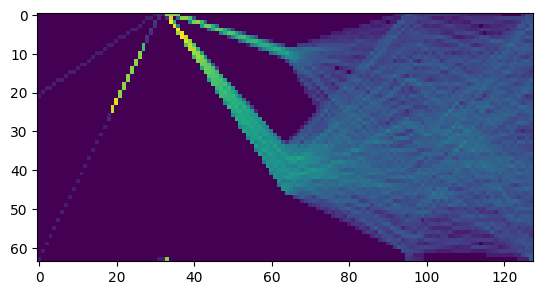

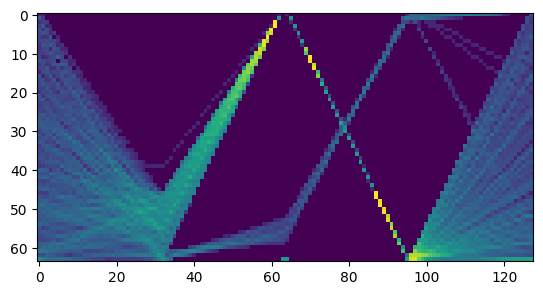

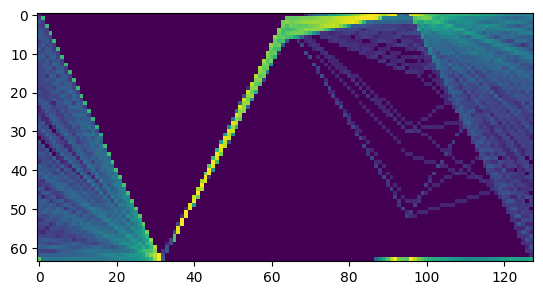

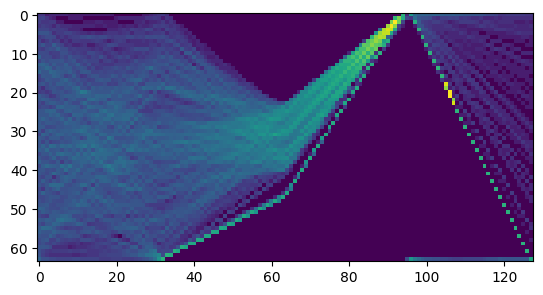

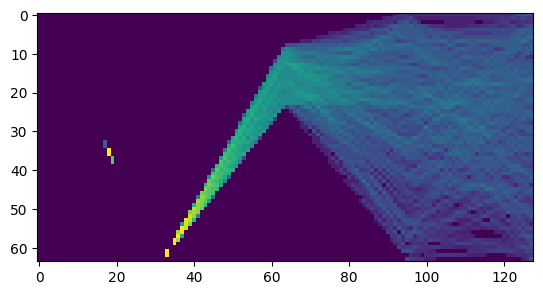

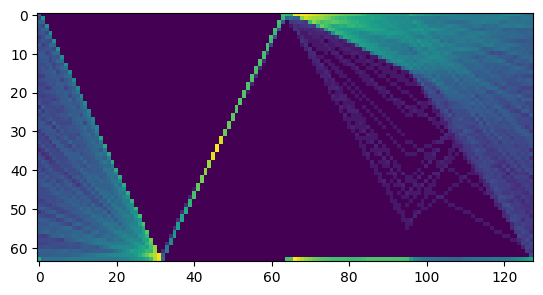

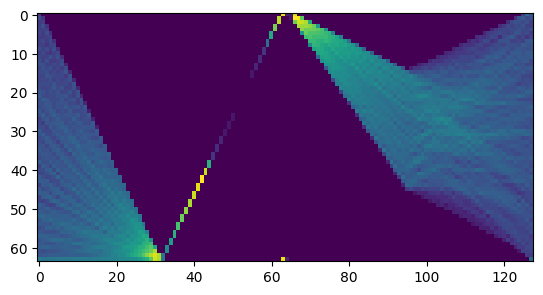

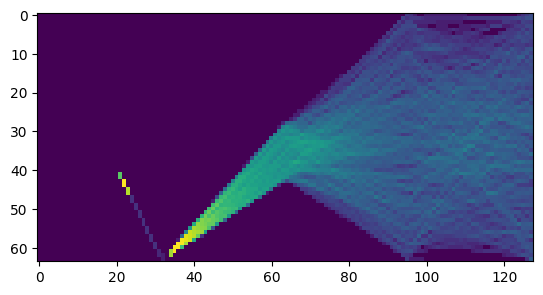

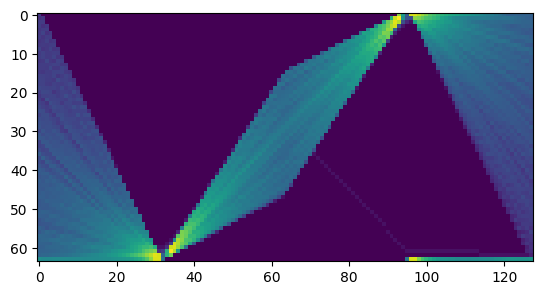

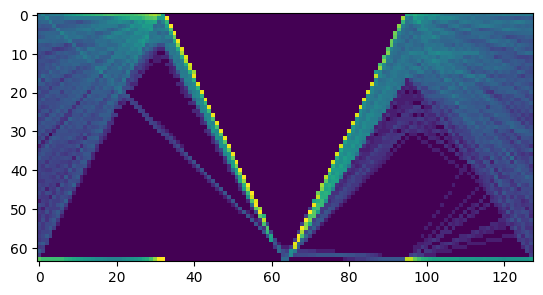

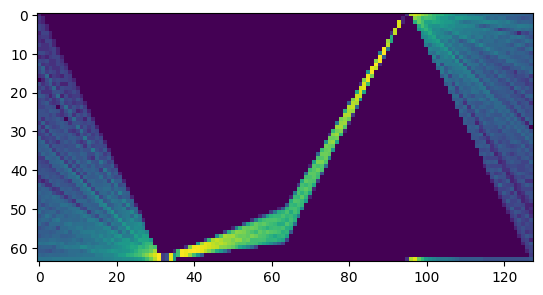

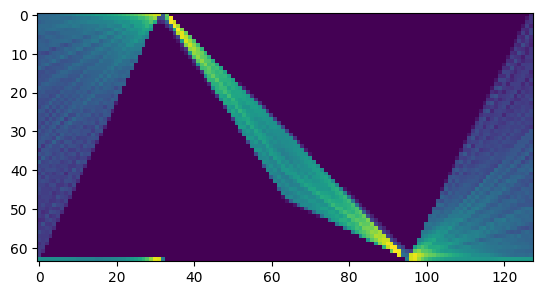

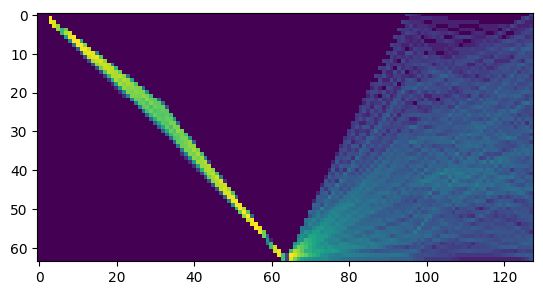

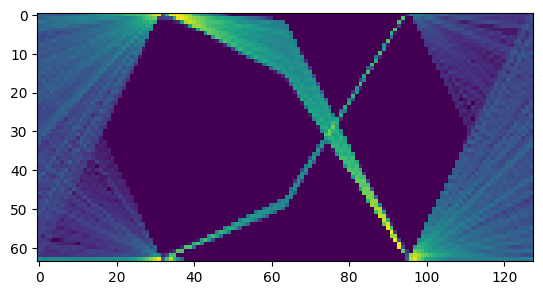

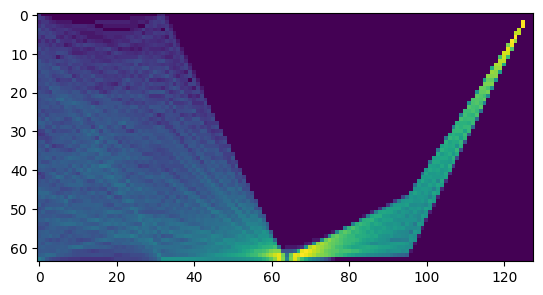

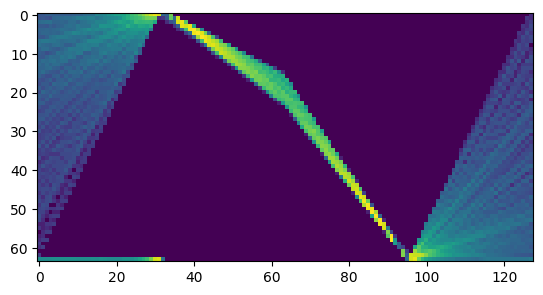

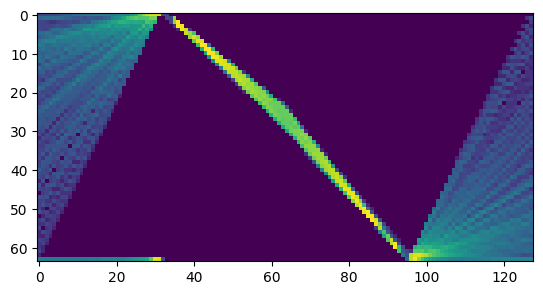

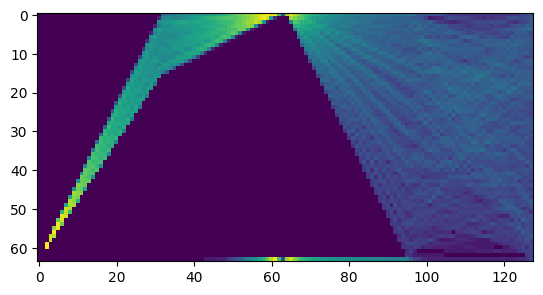

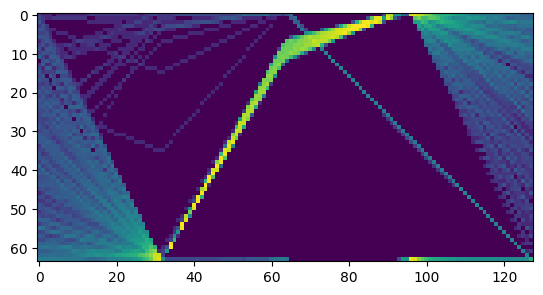

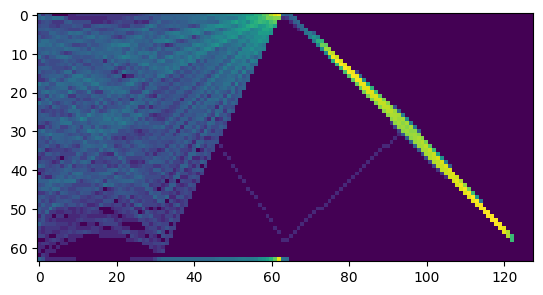

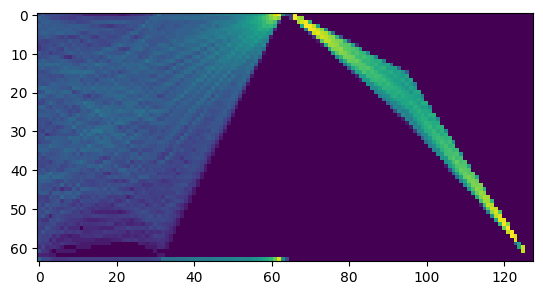

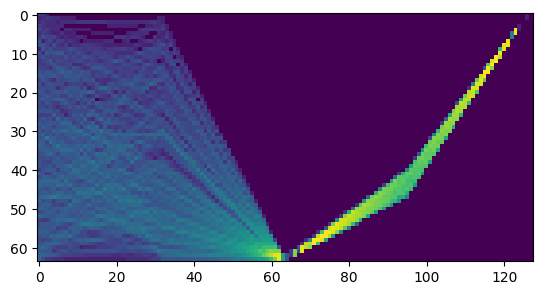

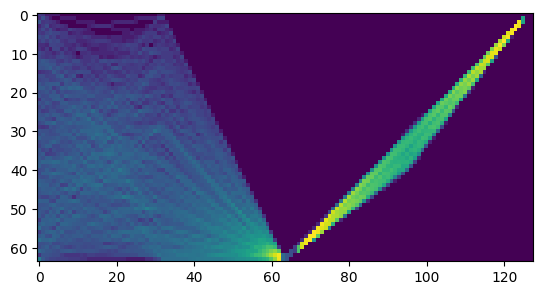

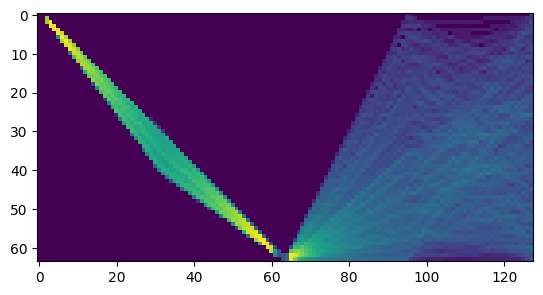

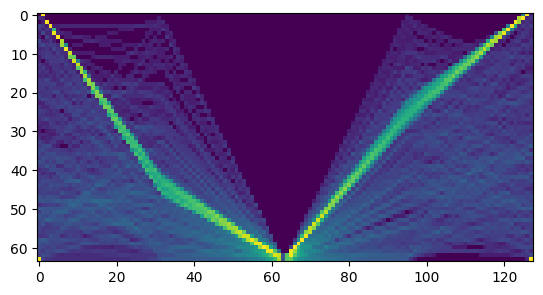

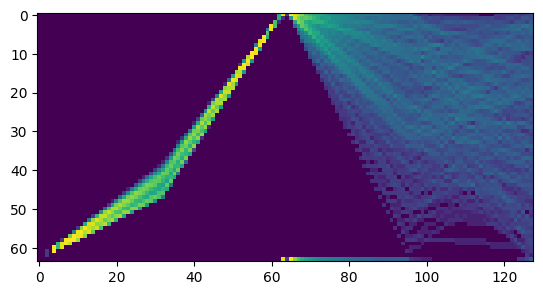

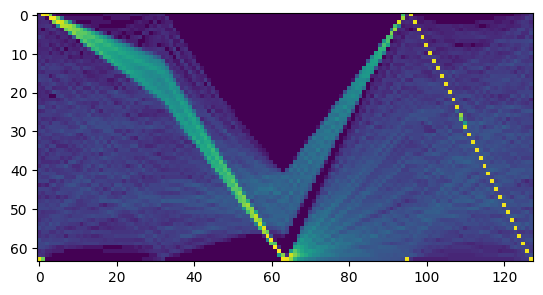

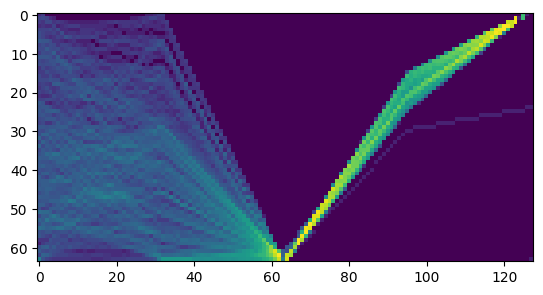

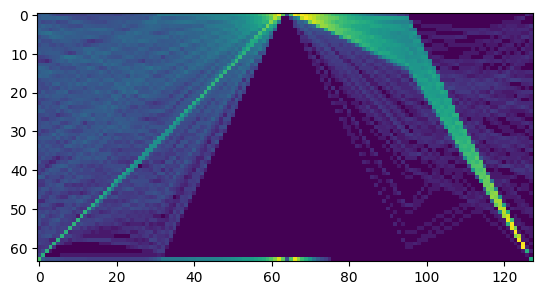

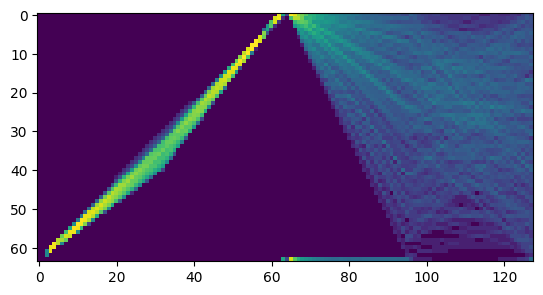

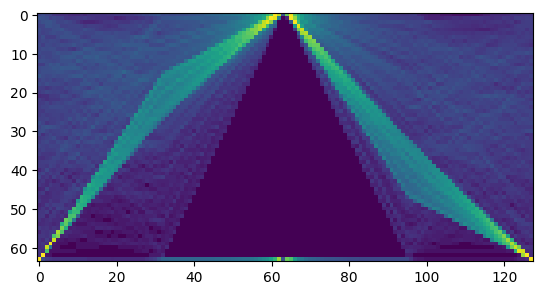

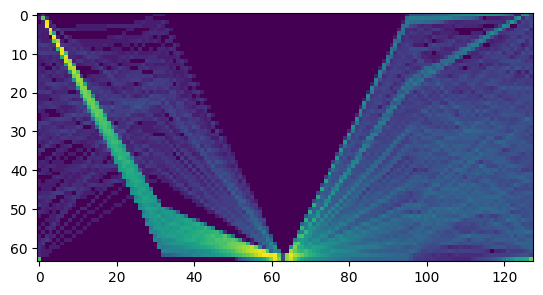

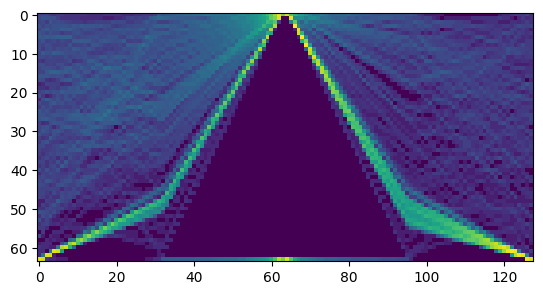

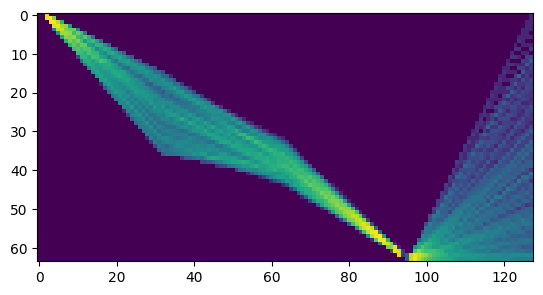

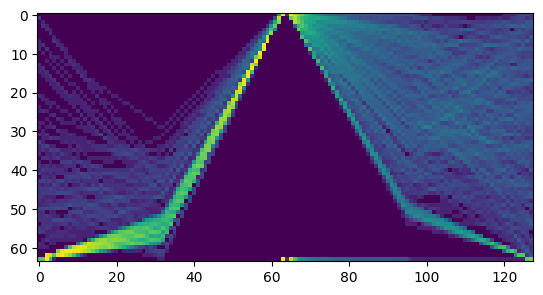

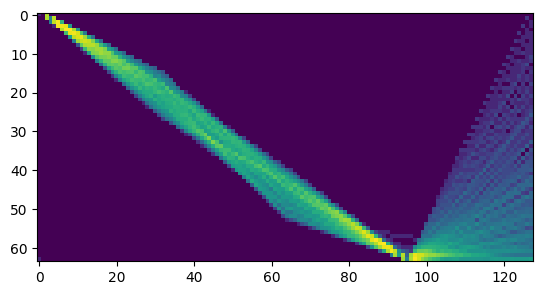

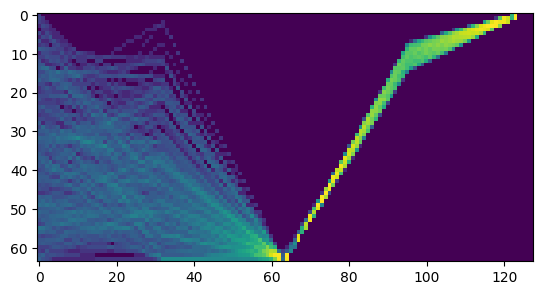

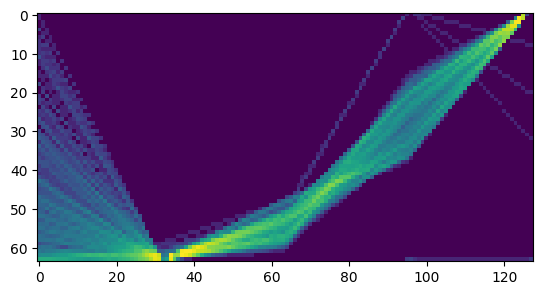

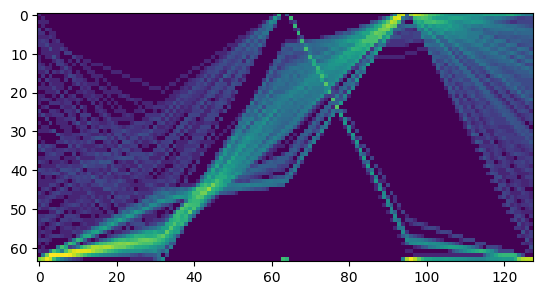

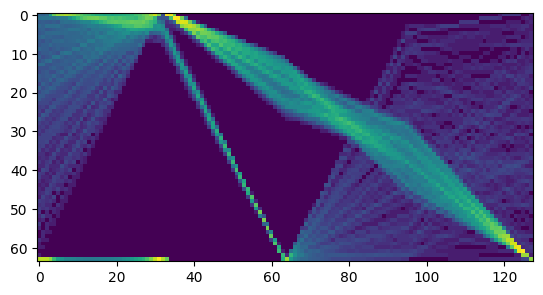

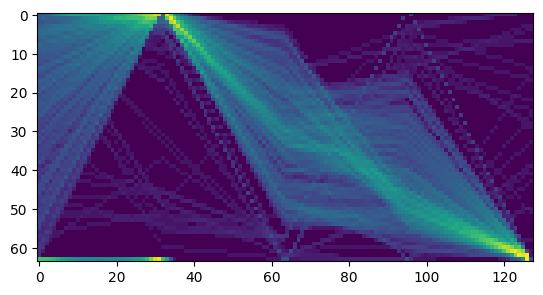

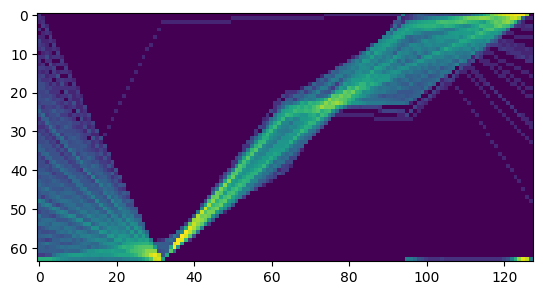

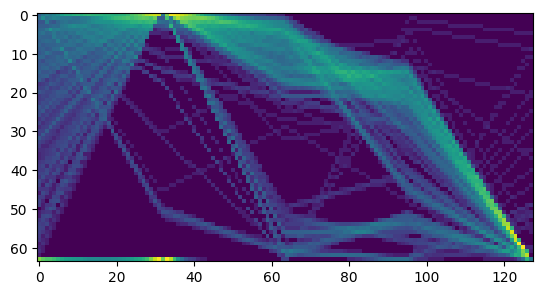

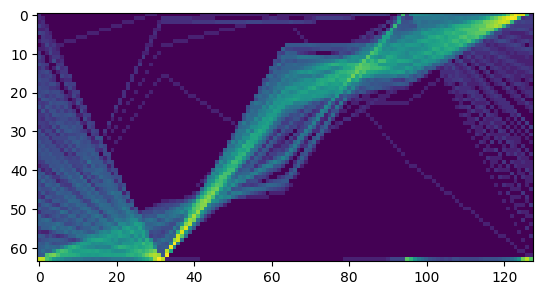

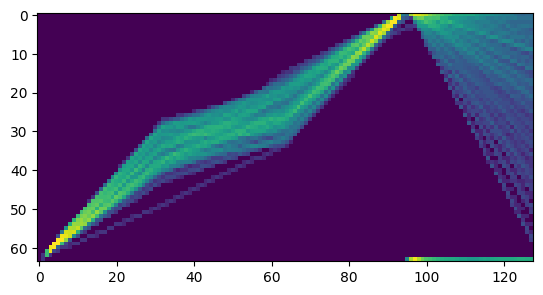

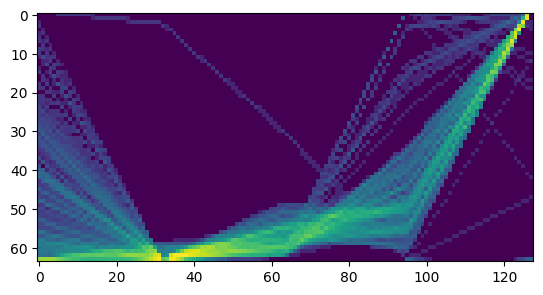

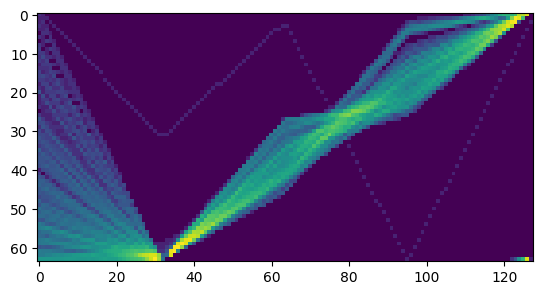

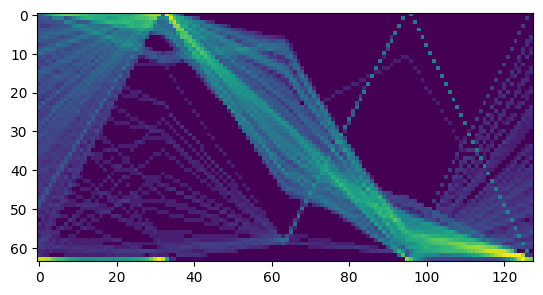

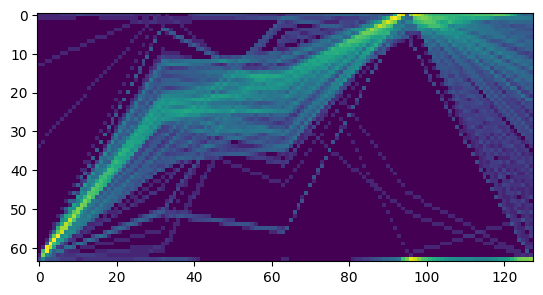

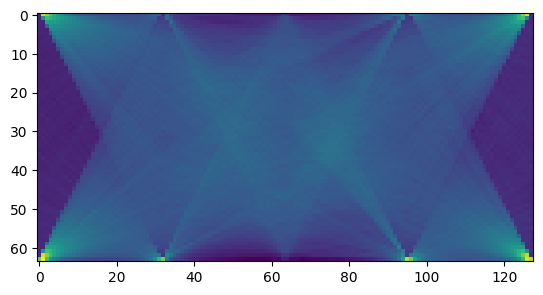

In [25]:
for label in std.keys():
    plt.imshow(std[label].reshape(64, 128))
    plt.show()

In [27]:
X = images[labels != -1]
Y = labels[labels != -1]

In [28]:
X.shape, Y.shape

((67520, 8192), (67520,))

(array([ 8693.,  3143.,  3034.,  6963.,  3880.,  3331.,  5791.,  2687.,
         3718., 26280.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

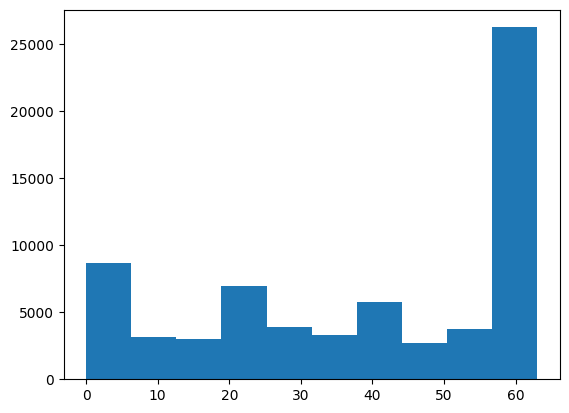

In [29]:
plt.hist(Y)

In [32]:
_, label_counts = np.unique(Y, return_counts=True)

In [37]:
label_counts[-1] - 6250

17478

In [72]:
X_indices = np.arange(X.shape[0])

In [76]:
remove_indices = np.random.choice(X_indices[Y == 63], 17478)

In [77]:
remove_indices.shape

(17478,)

In [78]:
Y.shape

(67520,)

In [82]:
X_pruned = X[X_indices[~np.isin(X_indices, remove_indices)]]

In [83]:
Y_pruned = Y[X_indices[~np.isin(X_indices, remove_indices)]]

(array([ 8693.,  3143.,  3034.,  6963.,  3880.,  3331.,  5791.,  2687.,
         3718., 13913.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

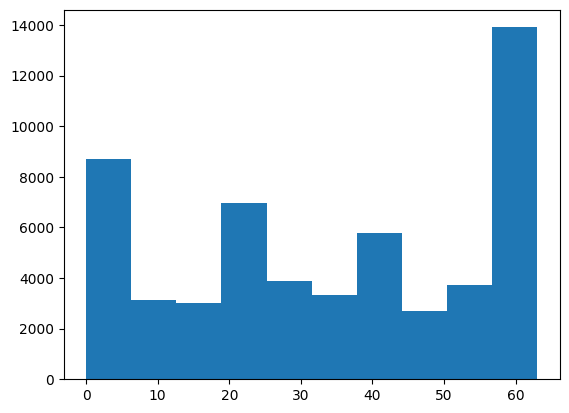

In [84]:
plt.hist(Y_pruned)

In [87]:
np.unique(Y_pruned, return_counts=True)[1].max()

11361

In [88]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [89]:
class ImagesData(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [95]:
indices = np.arange(X_pruned.shape[0])

In [96]:
np.random.shuffle(indices)

In [97]:
indices

array([17019, 36273, 51936, ..., 54233,  8867, 43364])

In [98]:
len(indices)

55153

In [99]:
n_train = int(.8 * len(indices))
n_test = len(indices) - n_train

In [100]:
X_train = X_pruned[indices[:n_train]]
Y_train = Y_pruned[indices[:n_train]]

X_test = X_pruned[indices[n_train:]]
Y_test = Y_pruned[indices[n_train:]]

In [101]:
X_train.shape, Y_train.shape

((44122, 8192), (44122,))

In [102]:
X_test.shape, Y_test.shape

((11031, 8192), (11031,))

In [103]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

In [104]:
train = ImagesData(X=X_train, Y=Y_train) 
test = ImagesData(X=X_test, Y=Y_test)

train = DataLoader(train, shuffle=True, batch_size=32)
test = DataLoader(test, shuffle=True, batch_size=32)

In [106]:
Y_train.unique().shape

torch.Size([64])

In [112]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Linear(8192, 64)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [126]:
net = LinearModel()

In [128]:
optimiser = torch.optim.Adam(net.parameters(), lr=1e-4)
lossfn = nn.CrossEntropyLoss()

In [116]:
from tqdm import tqdm

In [129]:
train_loss_over_time = []
train_accuracy_over_time = []

test_loss_over_time = []
test_accuracy_over_time = []

In [130]:
for epoch in range(10):
    running_train_loss = []
    running_train_accuracy = []
    
    running_test_loss = []
    running_test_accuracy = []
    
    for x, y in tqdm(train):
        optimiser.zero_grad()
        
        x = x.float()
        y = y.long()
        
        p = net(x)
        loss =  lossfn(p, y)
        accuracy = (p.argmax(-1) == y).float().mean()
        
        loss.backward()
        optimiser.step()
        
        running_train_loss.append(loss.item())
        running_train_accuracy.append(accuracy.item())
        
    with torch.no_grad():
        for x, y in tqdm(test):
            x = x.float()
            y = y.long()
            
            p = net(x)
            loss = lossfn(p, y)
            accuracy = (p.argmax(-1) == y).float().mean()
            
            running_test_loss.append(loss.item())
            running_test_accuracy.append(accuracy.item())
            
    train_loss = sum(running_train_loss) / len(running_train_loss)
    train_accuracy = sum(running_train_accuracy) / len(running_train_accuracy)
    
    test_loss = sum(running_test_loss) / len(running_test_loss)
    test_accuracy = sum(running_test_accuracy) / len(running_test_accuracy)
    
    train_loss_over_time.append(train_loss)
    train_accuracy_over_time.append(train_accuracy)
    
    test_loss_over_time.append(test_loss)
    test_accuracy_over_time.append(test_accuracy)
    
    print(f"Epoch : {epoch+1} | train_loss : {train_loss:.3f} | train_acc : {train_accuracy:.3f} | test_loss : {test_loss:.3f} | test_acc : {test_accuracy:.3f}")
            
            

100%|██████████| 345/345 [00:00<00:00, 620.41it/s]


Epoch : 1 | train_loss : 1.613 | train_acc : 0.685 | test_loss : 0.571 | test_acc : 0.920


100%|██████████| 345/345 [00:00<00:00, 640.09it/s]


Epoch : 2 | train_loss : 0.359 | train_acc : 0.951 | test_loss : 0.286 | test_acc : 0.951


100%|██████████| 345/345 [00:00<00:00, 667.60it/s]


Epoch : 3 | train_loss : 0.202 | train_acc : 0.964 | test_loss : 0.203 | test_acc : 0.958


100%|██████████| 345/345 [00:00<00:00, 667.54it/s]


Epoch : 4 | train_loss : 0.141 | train_acc : 0.972 | test_loss : 0.163 | test_acc : 0.963


100%|██████████| 345/345 [00:00<00:00, 657.12it/s]


Epoch : 5 | train_loss : 0.108 | train_acc : 0.978 | test_loss : 0.139 | test_acc : 0.966


100%|██████████| 345/345 [00:00<00:00, 669.88it/s]


Epoch : 6 | train_loss : 0.086 | train_acc : 0.983 | test_loss : 0.124 | test_acc : 0.968


100%|██████████| 345/345 [00:00<00:00, 511.15it/s]


Epoch : 7 | train_loss : 0.072 | train_acc : 0.986 | test_loss : 0.114 | test_acc : 0.968


100%|██████████| 345/345 [00:00<00:00, 641.69it/s]


Epoch : 8 | train_loss : 0.061 | train_acc : 0.989 | test_loss : 0.108 | test_acc : 0.970


100%|██████████| 345/345 [00:00<00:00, 667.38it/s]


Epoch : 9 | train_loss : 0.052 | train_acc : 0.990 | test_loss : 0.103 | test_acc : 0.970


100%|██████████| 345/345 [00:00<00:00, 675.31it/s]

Epoch : 10 | train_loss : 0.045 | train_acc : 0.991 | test_loss : 0.099 | test_acc : 0.971


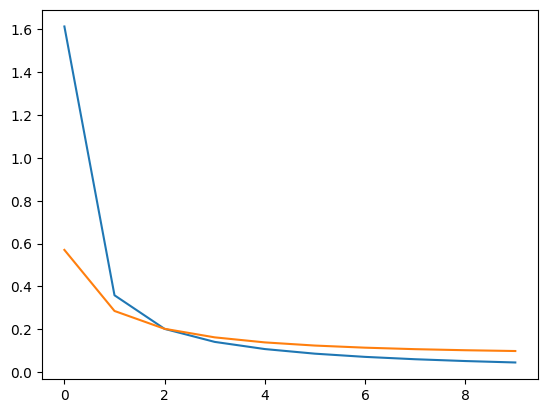

In [131]:
plt.plot(train_loss_over_time)
plt.plot(test_loss_over_time)

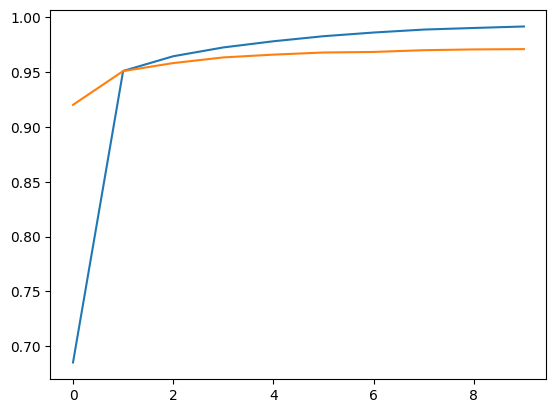

In [132]:
plt.plot(train_accuracy_over_time)
plt.plot(test_accuracy_over_time)

In [135]:
torch.save(LinearModel, "LinearModel.def.pth")
torch.save(net, "LinearModel.state_dict.pth")

torch.save({
    "train_loss_over_time": train_loss_over_time,
    "test_loss_over_time": test_loss_over_time,
    "train_accuracy_over_time": train_accuracy_over_time,
    "test_accuracy_over_time": test_accuracy_over_time,
}, "metrics.pth")

torch.save(X_train, "X_train.pth")
torch.save(Y_train, "Y_train.pth")
torch.save(X_test, "X_test.pth")
torch.save(Y_test, "X_test.pth")